In [12]:
import torch
import numpy as np
import cv2
import random
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
from torchvision import models

import torch.nn as nn
import torch.nn.functional as F
import torch.nn as nn
from torchvision import models

import torch
import numpy as np
import cv2
import random
import math
from torch.utils.data import Dataset, DataLoader


In [13]:
def make_curve_family(full_w: int, full_h: int, K: int) -> np.ndarray:
    """
    Generate K curves as y(x) centerlines.
    Output: ys shape [K, full_w] in pixel coords.
    """
    x = np.linspace(0, 1, full_w).astype(np.float32)

    # 1. Base trend: downward or upward
    trend = random.choice(["down", "up"])
    if trend == "down":
        base = (0.2 + 0.6 * (1 - x))
    else:
        base = (0.2 + 0.6 * x)

    # 2. Add smooth global curvature
    a1, a2 = random.uniform(-0.1, 0.1), random.uniform(-0.1, 0.1)
    curve = base + a1 * np.sin(2 * math.pi * x * random.uniform(0.8, 1.8)) + \
                   a2 * np.sin(2 * math.pi * x * random.uniform(1.8, 3.2))

    # Scale to pixel range
    margin = random.uniform(0.1, 0.18)
    y0_px, y1_px = margin * full_h, (1 - margin) * full_h
    curve_px = y0_px + (y1_px - y0_px) * curve

    ys = np.zeros((K, full_w), np.float32)
    spacing = random.uniform(12, 30)
    offsets = np.linspace(-(K-1)/2, (K-1)/2, K) * spacing
    random.shuffle(offsets)

    for k in range(K):
        # Add per-series smooth warps
        warp = random.uniform(2, 16) * np.sin(2 * math.pi * x * random.uniform(0.6, 2.4) + random.uniform(0, 2*math.pi))
        ys[k] = curve_px + offsets[k] + warp

    # 3. Local Confusion: Force near-crossing or merging
    if K >= 2 and random.random() < 0.65:
        for _ in range(random.randint(1, 2)):
            a, b = random.sample(range(K), 2)
            cx = random.randint(full_w//5, 4*full_w//5)
            bw = random.randint(40, 120)
            lo, hi = max(0, cx-bw//2), min(full_w-1, cx+bw//2)
            
            t = np.linspace(-1, 1, hi-lo).astype(np.float32)
            blend = np.exp(-0.5 * (t / 0.4)**2) # Gaussian bell
            
            mid = 0.5 * (ys[a, lo:hi] + ys[b, lo:hi])
            if random.random() < 0.5:
                ys[a, lo:hi] = ys[a, lo:hi]*(1-blend) + mid*blend
                ys[b, lo:hi] = ys[b, lo:hi]*(1-blend) + mid*blend
            else: # Swap ordering locally
                ya, yb = ys[a, lo:hi].copy(), ys[b, lo:hi].copy()
                ys[a, lo:hi] = ya*(1-blend) + yb*blend
                ys[b, lo:hi] = yb*(1-blend) + ya*blend

    return np.clip(ys, 5, full_h-5)

class RealisticVariableSnapDataset(Dataset):
    def __init__(self, n_samples=5000, h=256, w=512, win_w=64, max_curves=8):
        self.n = n_samples
        self.h = h
        self.w = w
        self.win_w = win_w
        self.max_curves = max_curves
        
        # Configuration for realism (derived from SynthConfig)
        self.thickness_range = (2, 4)
        self.marker_prob = 0.4
        self.ci_prob = 0.25
        self.drift_prob = 0.6
        self.drift_amp_range = (4.0, 26.0)
        self.drift_smooth_sigma = (10.0, 35.0)

    def __len__(self):
        return self.n

    def __getitem__(self, idx):
        # 1. Randomly decide K for this sample
        num_curves = random.randint(1, self.max_curves)
        
        # 2. Generate Realistic Curve Family
        # We generate full-width curves first to calculate smooth drift
        ys_true = make_curve_family(self.w, self.h, num_curves) 
        
        # 3. Generate Realistic Priors (Trajectories with Drift)
        # Instead of a heatmap, we generate 1D trajectories that 'drift' from the truth
        priors_full = self._build_drifted_priors(ys_true)
        
        # 4. Render Realistic Image
        # Includes JPEG noise, speckle, and background textures
        colors = [random_color_gen() for _ in range(num_curves)]
        full_img = render_full_image_no_axes_internal(self.h, self.w, ys_true, colors)
        
        # 5. Window Sampling (Vertical Strip)
        x_center = random.randint(self.win_w // 2, self.w - self.win_w // 2 - 1)
        x0, x1 = x_center - self.win_w // 2, x_center + self.win_w // 2
        
        rgb_win = full_img[:, x0:x1, :]
        
        # 6. Padding and Masking (Up to Max Curves)
        padded_priors = torch.zeros((self.max_curves, self.win_w))
        padded_targets = torch.zeros(self.max_curves)
        mask = torch.zeros(self.max_curves)
        
        for k in range(num_curves):
            # Prior for this window
            prior_segment = priors_full[k, x0:x1]
            padded_priors[k] = torch.from_numpy(prior_segment).float() / (self.h - 1)
            
            # Target is the centerline Y at the exact center column
            padded_targets[k] = torch.tensor(ys_true[k, x_center] / (self.h - 1)).float()
            mask[k] = 1.0

        img_t = torch.from_numpy(rgb_win).permute(2, 0, 1).float() / 255.0
        
        return img_t, padded_priors, padded_targets, mask

    def _build_drifted_priors(self, ys_true):
        K, W = ys_true.shape
        priors = ys_true.copy().astype(np.float32)
        
        for k in range(K):
            # Add base jitter
            priors[k] += np.random.normal(0, random.uniform(2.0, 5.0), size=W)
            
            # Add smooth correlated drift
            if random.random() < self.drift_prob:
                amp = random.uniform(*self.drift_amp_range)
                sig = random.uniform(*self.drift_smooth_sigma)
                priors[k] += smooth_random_drift_internal(W, amp, sig)
        
        return np.clip(priors, 0, self.h - 1)

# Helper functions for the realistic rendering pipeline
def smooth_random_drift_internal(W, amp, sigma):
    d = np.random.normal(0, 1, (W,)).astype(np.float32)
    d = cv2.GaussianBlur(d.reshape(1, -1), (0, 0), sigmaX=sigma).reshape(-1)
    d = d / (np.std(d) + 1e-6)
    return d * amp

def random_color_gen():
    return tuple(int(x) for x in np.random.randint(30, 220, size=3))

def render_full_image_no_axes_internal(H, W, ys, colors):
    img = np.ones((H, W, 3), np.uint8) * 255
    K = ys.shape[0]
    
    for k in range(K):
        color = colors[k]
        pts = np.stack([np.arange(W), ys[k]], axis=1).astype(np.int32)
        # Randomize linestyle
        style = random.choice(['solid', 'dashed', 'dotted'])
        if style == 'solid':
            cv2.polylines(img, [pts], False, color, 2, cv2.LINE_AA)
        elif style == 'dashed':
            for i in range(0, W-10, 20):
                cv2.polylines(img, [pts[i:i+12]], False, color, 2, cv2.LINE_AA)
        
        # Add realistic CI bars occasionally
        if random.random() < 0.25:
            for x in range(random.randint(0,20), W, random.randint(60, 100)):
                y = int(ys[k, x])
                cv2.line(img, (x, y-15), (x, y+15), color, 1, cv2.LINE_AA)

    # Add image-level noise (JPEG/Blur/Speckle)
    return add_image_noise_internal(img)

def add_image_noise_internal(img):
    # Quick implementation of the noise models from the new script
    out = img.copy()
    if random.random() < 0.3: # Blur
        out = cv2.GaussianBlur(out, (3, 3), 0)
    if random.random() < 0.3: # Speckle
        noise = np.random.normal(0, 5, out.shape).astype(np.uint8)
        out = cv2.add(out, noise)
    return out

In [14]:
class VariableCurveSnapperNet(nn.Module):
    def __init__(self, win_w=64, max_curves=8):
        super().__init__()
        base = models.resnet18(weights='DEFAULT')
        base.conv1 = nn.Conv2d(4, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.backbone = nn.Sequential(*list(base.children())[:-2]) 
        self.compress = nn.Sequential(nn.Conv2d(512, 128, 1), nn.BatchNorm2d(128), nn.ReLU())
        
        # Prior Encoder handles [Batch, 8, win_w]
        self.prior_mlp = nn.Sequential(
            nn.Linear(max_curves * win_w, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU()
        )

        self.regressor = nn.Sequential(
            nn.Linear(128 * 8 * 2 + 256, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, max_curves), # Always output 8 values
            nn.Sigmoid() 
        )

    def forward(self, img, priors):
        b, _, h, w = img.shape
        y_map = torch.linspace(0, 1, h, device=img.device).view(1, 1, h, 1).expand(b, 1, h, w)
        x = torch.cat([img, y_map], dim=1) 

        v_feat = self.compress(self.backbone(x)).flatten(1)
        p_feat = self.prior_mlp(priors.view(b, -1))
        
        return self.regressor(torch.cat([v_feat, p_feat], dim=1))

In [35]:
def train_snapper(model, val_loader, epochs=20, window_size=64, window_height=256, patience=10):
    criterion = torch.nn.SmoothL1Loss(reduction='none') 
    
    # Using a slightly higher max_lr because OneCycleLR handles the cooling
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
    
    # OneCycleLR is great for regenerative datasets as it helps explore the 
    # complex noise profile quickly then settle into high precision.
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer, 
        max_lr=1e-4, 
        steps_per_epoch=1, # We update per epoch in this setup
        epochs=epochs
    )

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    best_val_px_err = 1e9
    epochs_no_improve = 0

    for epoch in range(epochs):
        # Regenerate fresh data: The dataset is never 'finished'
        train_dataset = RealisticVariableSnapDataset(n_samples=10000, win_w=window_size, h=window_height)
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

        model.train()
        total_train_loss = 0
        
        for imgs, priors, targets, masks in train_loader:
            imgs, priors, targets, masks = imgs.to(device), priors.to(device), targets.to(device), masks.to(device)
            
            output = model(imgs, priors)
            
            # Loss in pixel space for robust gradients
            loss_matrix = criterion(output * window_height, targets * window_height)
            masked_loss = (loss_matrix * masks).sum() / (masks.sum() + 1e-8)
            
            optimizer.zero_grad()
            masked_loss.backward()
            optimizer.step()
            
            total_train_loss += masked_loss.item()

        # --- Validation Phase ---
        model.eval()
        total_val_px_err = 0
        val_curve_count = 0
        with torch.no_grad():
            for imgs, priors, targets, masks in val_loader:
                imgs, priors, targets, masks = imgs.to(device), priors.to(device), targets.to(device), masks.to(device)
                
                output = model(imgs, priors)
                abs_diff = torch.abs(output * window_height - targets * window_height)
                
                total_val_px_err += (abs_diff * masks).sum().item()
                val_curve_count += masks.sum().item()

        avg_train = total_train_loss / len(train_loader)
        avg_val_px_err = total_val_px_err / (val_curve_count + 1e-8)
        
        # Step the scheduler
        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']

        # --- Early Stopping & Saving ---
        if avg_val_px_err < best_val_px_err:
            best_val_px_err = avg_val_px_err
            epochs_no_improve = 0
            torch.save(model.state_dict(), "best_snapper.pth")
            status = f"(Best! Error: {avg_val_px_err:.2f}px)"
        else:
            epochs_no_improve += 1
            status = f"(No improve for {epochs_no_improve} epochs)"
        
        print(f"Epoch {epoch+1:02d}/{epochs} | LR: {current_lr:.6f} | Train Loss: {avg_train:.4f} | Val Err: {avg_val_px_err:.2f}px {status}")

        if epochs_no_improve >= patience:
            print(f"\nEarly stopping triggered. No improvement for {patience} epochs.")
            break
    
    # Load the best weights before returning
    model.load_state_dict(torch.load("best_snapper.pth"))
    return model

In [36]:
def visualize_snapping(model, dataset, num_samples=3):
    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import random
    
    model.eval()
    device = next(model.parameters()).device
    h, win_w = dataset.h, dataset.win_w
    center_x = win_w // 2
    
    # Using 'tab10' colormap for up to 8 distinct, high-contrast colors
    colors = cm.get_cmap('tab10', 8)
    
    fig, axes = plt.subplots(num_samples, 1, figsize=(12, 6 * num_samples))
    if num_samples == 1: axes = [axes]

    with torch.no_grad():
        for i in range(num_samples):
            # 1. Get random sample and send to device
            idx = random.randint(0, len(dataset)-1)
            img_t, priors_t, targets_t, mask = dataset[idx]
            
            # 2. Prediction (Expects [1, 8, win_w])
            output = model(img_t.unsqueeze(0).to(device), priors_t.unsqueeze(0).to(device))
            preds_px = output.squeeze().cpu().numpy() * h
            
            # 3. Prep coordinates for plotting
            img_np = img_t.permute(1, 2, 0).cpu().numpy()
            priors_px = priors_t.cpu().numpy() * h
            targets_px = targets_t.cpu().numpy() * h
            x_axis = np.arange(win_w)
            
            axes[i].imshow(img_np)
            
            # 4. Iterate through the mask to only plot the actual data
            num_active = int(mask.sum().item())
            total_err = 0
            
            for j in range(num_active):
                c = colors(j)
                err_px = abs(preds_px[j] - targets_px[j])
                total_err += err_px
                
                # Plot the drifted Prior Trajectory (Dashed/Transparent)
                axes[i].plot(x_axis, priors_px[j], color=c, linestyle='--', alpha=0.4, linewidth=1)
                
                # Plot the Ground Truth (Small circle)
                axes[i].scatter(center_x, targets_px[j], color=c, s=100, 
                                edgecolors='white', linewidth=1.5, zorder=5)
                
                # Plot the Model Prediction (Bright Star)
                axes[i].scatter(center_x, preds_px[j], color=c, marker='*', s=200, 
                                edgecolors='black', linewidth=1, zorder=6)
                
                # Label the Pixel Difference next to the snap
                axes[i].text(center_x + 3, preds_px[j], f"{err_px:.1f}px", 
                             color=c, fontsize=10, fontweight='bold',
                             bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', pad=1))

            avg_err = total_err / num_active if num_active > 0 else 0
            axes[i].set_title(f"Sample {idx} | Curves: {num_active} | Avg Snap Error: {avg_err:.2f}px")
            
    plt.tight_layout()
    plt.show()

In [37]:
# --- SETTINGS ---
H = 256
WIN_W = 64
BATCH_SIZE = 32
EPOCHS = 50

# 1. Initialize Datasets (Separate samples for Train and Val)
val_dataset = RealisticVariableSnapDataset(n_samples=1000)

# 2. Create DataLoaders
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# 3. Initialize Model
model = VariableCurveSnapperNet(win_w=WIN_W)

# 4. START TRAINING WITH VALIDATION
print("Starting training with validation...")
trained_model = train_snapper(
    model,  
    val_loader, 
    epochs=EPOCHS,
    window_size=WIN_W
)

# 5. SAVE AND TEST
torch.save(trained_model.state_dict(), "curve_snapper_validated.pth")

Starting training with validation...
Epoch 01/50 | LR: 0.000005 | Train Loss: 32.3005 | Val Err: 30.27px (Best! Error: 30.27px)
Epoch 02/50 | LR: 0.000009 | Train Loss: 27.3485 | Val Err: 23.14px (Best! Error: 23.14px)
Epoch 03/50 | LR: 0.000014 | Train Loss: 16.7666 | Val Err: 11.64px (Best! Error: 11.64px)
Epoch 04/50 | LR: 0.000022 | Train Loss: 13.4339 | Val Err: 11.28px (Best! Error: 11.28px)
Epoch 05/50 | LR: 0.000031 | Train Loss: 12.5437 | Val Err: 10.02px (Best! Error: 10.02px)
Epoch 06/50 | LR: 0.000041 | Train Loss: 12.3523 | Val Err: 10.36px (No improve for 1 epochs)
Epoch 07/50 | LR: 0.000052 | Train Loss: 12.0774 | Val Err: 10.20px (No improve for 2 epochs)
Epoch 08/50 | LR: 0.000063 | Train Loss: 11.7608 | Val Err: 10.33px (No improve for 3 epochs)
Epoch 09/50 | LR: 0.000073 | Train Loss: 11.5418 | Val Err: 10.30px (No improve for 4 epochs)
Epoch 10/50 | LR: 0.000082 | Train Loss: 11.2956 | Val Err: 10.00px (Best! Error: 10.00px)
Epoch 11/50 | LR: 0.000090 | Train Loss: 

In [38]:
def compute_pixel_metrics(model, loader, device, h=256):
    model.eval()
    all_errors = []

    with torch.no_grad():
        for imgs, priors, targets, masks in loader:
            imgs, priors, targets, masks = imgs.to(device), priors.to(device), targets.to(device), masks.to(device)
            
            # Get model output [Batch, 8]
            output = model(imgs, priors)
            
            # Convert to pixel coordinates
            output_px = output * h
            targets_px = targets * h
            
            # Compute absolute difference
            abs_diff = torch.abs(output_px - targets_px) # [Batch, 8]
            
            # Extract only the errors for active curves using the mask
            # .masked_select returns a 1D tensor of only the "True" values
            active_errors = torch.masked_select(abs_diff, masks.bool())
            
            all_errors.append(active_errors.cpu())

    if not all_errors:
        return 0.0, 0.0

    # Combine all individual curve errors into one large 1D tensor
    all_errors_tensor = torch.cat(all_errors)
    
    mean_error = torch.mean(all_errors_tensor).item()
    median_error = torch.median(all_errors_tensor).item()
    
    return mean_error, median_error

# Usage:
mean_err, median_err = compute_pixel_metrics(model, val_loader, "cuda", h=256)
print(f"Mean Error: {mean_err:.2f}px | Median Error: {median_err:.2f}px")

Mean Error: 7.54px | Median Error: 4.94px


C:\Users\remi_\AppData\Local\Temp\ipykernel_29732\335911606.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', 8)


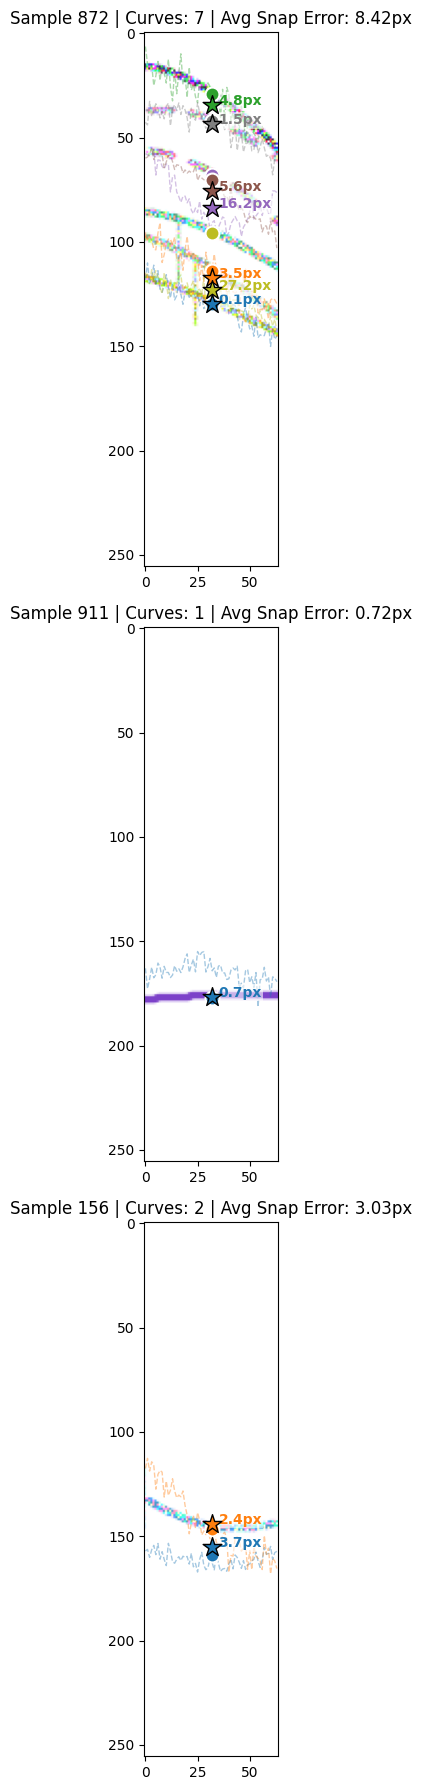

In [41]:
visualize_snapping(trained_model, val_dataset)

### 2 priors 2 curves

In [115]:
class VariableSnapDataset(Dataset):
    def __init__(self, n_samples=5000, h=256, win_w=64, max_curves=8):
        self.n = n_samples
        self.h, self.w, self.win_w = h, 512, win_w
        self.max_curves = max_curves

    def __len__(self): return self.n

    def __getitem__(self, idx):
        # 1. Randomly decide how many curves to generate (1 to 8)
        num_curves = random.randint(1, self.max_curves)
        
        ys = []
        priors = []
        targets = []
        
        for i in range(num_curves):
            # Generate curve
            y = np.clip(random.randint(60, 190) + np.cumsum(np.random.normal(0, 2.2, self.w)), 10, self.h-10)
            ys.append(y)
            
            # Generate noisy prior
            drift = np.cumsum(np.random.normal(0, 1.8, self.w))
            jitter = np.random.normal(0, 2.5, self.w)
            prior_full = np.clip(y + drift + jitter, 0, self.h-1)
            
            x_center = random.randint(self.win_w, self.w - self.win_w)
            x0, x1 = x_center - self.win_w//2, x_center + self.win_w//2
            
            priors.append(torch.from_numpy(prior_full[x0:x1]).float() / self.h)
            targets.append(y[x_center] / self.h)

        # 2. PADDING: Fill the rest with zeros to maintain shape [8, win_w]
        # We also create a mask to tell the loss function which curves are real
        mask = torch.zeros(self.max_curves)
        mask[:num_curves] = 1.0
        
        padded_priors = torch.zeros((self.max_curves, self.win_w))
        padded_targets = torch.zeros(self.max_curves)
        
        for i in range(num_curves):
            padded_priors[i] = priors[i]
            padded_targets[i] = targets[i]

        img = render_realistic_img(ys, self.h, self.w) #
        img_t = torch.from_numpy(img[:, x0:x1]).permute(2,0,1).float() / 255.0

        return img_t, padded_priors, padded_targets, mask

In [109]:
class VariableCurveSnapperNet(nn.Module):
    def __init__(self, win_w=64, max_curves=8):
        super().__init__()
        base = models.resnet18(weights='DEFAULT')
        base.conv1 = nn.Conv2d(4, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.backbone = nn.Sequential(*list(base.children())[:-2]) 
        self.compress = nn.Sequential(nn.Conv2d(512, 128, 1), nn.BatchNorm2d(128), nn.ReLU())
        
        # Prior Encoder handles [Batch, 8, win_w]
        self.prior_mlp = nn.Sequential(
            nn.Linear(max_curves * win_w, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU()
        )

        self.regressor = nn.Sequential(
            nn.Linear(128 * 8 * 2 + 256, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, max_curves), # Always output 8 values
            nn.Sigmoid() 
        )

    def forward(self, img, priors):
        b, _, h, w = img.shape
        y_map = torch.linspace(0, 1, h, device=img.device).view(1, 1, h, 1).expand(b, 1, h, w)
        x = torch.cat([img, y_map], dim=1) 

        v_feat = self.compress(self.backbone(x)).flatten(1)
        p_feat = self.prior_mlp(priors.view(b, -1))
        
        return self.regressor(torch.cat([v_feat, p_feat], dim=1))

In [118]:
def train_variable_snapper(model, val_loader, epochs=10, window_size=256):
    # Reduction='none' allows us to apply the mask before averaging
    criterion = torch.nn.SmoothL1Loss(reduction='none') 
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    best_val_err = 1e9

    for epoch in range(epochs):
        # 1. Dataset Regeneration: Fresh data every epoch
        train_dataset = VariableSnapDataset(n_samples=10000, win_w=window_size)
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

        model.train()
        total_train_loss = 0
        
        for imgs, priors, targets, masks in train_loader:
            imgs, priors, targets, masks = imgs.to(device), priors.to(device), targets.to(device), masks.to(device)
            
            # Forward pass: Output is [Batch, 8]
            output = model(imgs, priors)
            
            # Pixel-scale loss calculation (0-256)
            # This prevents the gradient vanishing seen in normalized space
            raw_loss = criterion(output * window_size, targets * window_size) 
            
            # 2. Apply Mask: Ignore padded 'zero' curves
            masked_loss = (raw_loss * masks).sum() / (masks.sum() + 1e-8)
            
            optimizer.zero_grad()
            masked_loss.backward()
            optimizer.step()
            
            total_train_loss += masked_loss.item()

        # --- VALIDATION PHASE ---
        model.eval()
        total_px_err = 0.0
        total_curves = 0
        
        with torch.no_grad():
            for imgs, priors, targets, masks in val_loader:
                imgs, priors, targets, masks = imgs.to(device), priors.to(device), targets.to(device), masks.to(device)
                
                output = model(imgs, priors)
                
                # Calculate absolute pixel difference
                abs_diff = torch.abs(output * window_size - targets * window_size)
                
                # Sum error only for curves that actually exist (mask == 1)
                total_px_err += (abs_diff * masks).sum().item()
                total_curves += masks.sum().item()

        avg_train_loss = total_train_loss / len(train_loader)
        avg_val_px_err = total_px_err / (total_curves + 1e-8)
        
        scheduler.step(avg_val_px_err)

        # 3. Saving and Status
        status = ""
        if avg_val_px_err < best_val_err:
            best_val_err = avg_val_px_err
            torch.save(model.state_dict(), "best_variable_snapper.pth")
            status = "(Best!)"
        
        print(f"Epoch {epoch+1:02d} | Train Loss: {avg_train_loss:.4f} | Val Err: {avg_val_px_err:.2f}px {status}")
    
    return model

In [120]:
# --- SETTINGS ---
H = 256
WIN_W = 64
BATCH_SIZE = 64
EPOCHS = 3

# 1. Initialize Datasets (Separate samples for Train and Val)
val_dataset = VariableSnapDataset(n_samples=1000)

# 2. Create DataLoaders
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# 3. Initialize Model
model = VariableCurveSnapperNet(win_w=WIN_W)

# 4. START TRAINING WITH VALIDATION
print("Starting training with validation...")
trained_model = train_variable_snapper(
    model,  
    val_loader, 
    epochs=EPOCHS,
    window_size=WIN_W
)

# 5. SAVE AND TEST
torch.save(trained_model.state_dict(), "snapper.pth")

Starting training with validation...
Epoch 01 | Train Loss: 5.6871 | Val Err: 4.96px (Best!)
Epoch 02 | Train Loss: 4.7594 | Val Err: 4.71px (Best!)
Epoch 03 | Train Loss: 4.5848 | Val Err: 4.64px (Best!)


In [123]:
def visualize_variable_snapping(model, dataset, num_samples=3):
    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    
    model.eval()
    device = next(model.parameters()).device
    h, win_w = dataset.h, dataset.win_w
    center_x = win_w // 2
    
    # Use a colormap for up to 8 distinct colors
    colors = cm.get_cmap('tab10', 8)
    
    fig, axes = plt.subplots(num_samples, 1, figsize=(12, 6 * num_samples))
    if num_samples == 1: axes = [axes]

    with torch.no_grad():
        for i in range(num_samples):
            # 1. Get sample and mask
            img_t, priors_t, targets_t, mask = dataset[random.randint(0, len(dataset)-1)]
            
            # 2. Prediction
            output = model(img_t.unsqueeze(0).to(device), priors_t.unsqueeze(0).to(device))
            preds_px = output.squeeze().cpu().numpy() * h
            
            img_np = img_t.permute(1, 2, 0).cpu().numpy()
            priors_px = priors_t.cpu().numpy() * h
            targets_px = targets_t.cpu().numpy() * h
            
            axes[i].imshow(img_np)
            x_axis = np.arange(win_w)
            
            # 3. Iterate through the mask to only plot existing curves
            num_active = int(mask.sum().item())
            for j in range(num_active):
                c = colors(j)
                # Plot Noisy Prior (Dashed)
                axes[i].plot(x_axis, priors_px[j], color=c, linestyle='--', alpha=0.4)
                # Plot Ground Truth (Circle)
                axes[i].scatter(center_x, targets_px[j], color=c, s=100, edgecolors='white', linewidth=1)
                # Plot Prediction (Star)
                axes[i].scatter(center_x, preds_px[j], color=c, marker='*', s=180, edgecolors='black')
                
                # Add a small text label for error
                err = abs(preds_px[j] - targets_px[j])
                axes[i].text(center_x + 2, preds_px[j], f"{err:.1f}px", color=c, fontsize=9, fontweight='bold')

            axes[i].set_title(f"Sample {i} | Curves Present: {num_active}")
            
    plt.tight_layout()
    plt.show()

C:\Users\remi_\AppData\Local\Temp\ipykernel_31728\255239907.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', 8)


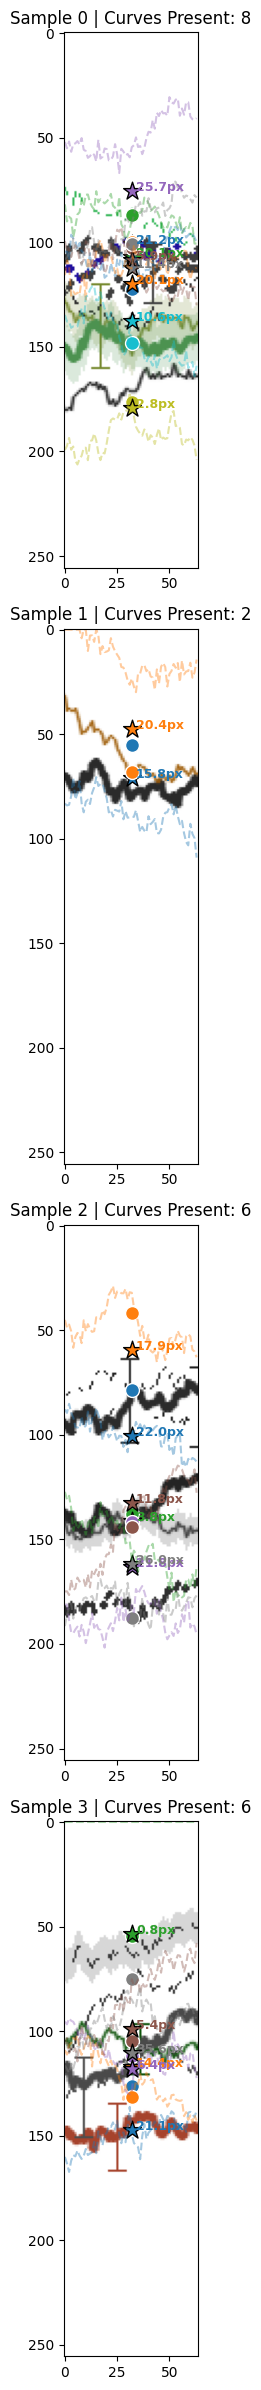

In [124]:
model = VariableCurveSnapperNet(win_w=64)
model.load_state_dict(torch.load("best_variable_snapper.pth"))
model.to("cuda")

# 2. Create a small validation dataset for visualization
viz_dataset = VariableSnapDataset(n_samples=100)

# 3. Call the visualization
visualize_variable_snapping(model, viz_dataset, num_samples=4)